# CellAssign results

Notebook showing cellAssign results with new taxonomy from Nick.

`cell_types` composed in https://github.com/NIH-CARD/brain-taxonomy

```python
cell_types = [
    "oligo",
    "opc",
    "glutamatergic",
    "gabergic",
    "protoplasmic_astrocyte",
    "fibrous_astrocyte",
    "microglia",
    "t_cell",
    "b_cell",
    "pericyte",
    "endothelial",
    "unknown",
]
```

----


Outline:

- setup:  imports, helper_functions, data path definitions
- get predictions (fit `cellassign` model)
- assess predictions
    - clean vs. full set of samples
    - cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
    - repititions / seeds


## setup  
- imports 
- helper_functions 
- data path definitions

In [1]:
import sys
import os

import scanpy as sc
import anndata as ad
from pathlib import Path
import scipy.sparse as sp
import pandas as pd
import numpy as np
import scvi

# %%
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath("/home/ergonyc/Projects/SingleCell/labelator/"))

In [2]:
XYLENA2_RAW_PATH = "data/scdata/xylena_raw"
XYLENA2_PATH = "data/scdata/xylena"

# FULL data is both "clean" (train+test) and "dirty" samples which were originally left out of the dataset
XYLENA2_FULL = "xyl2_full.h5ad"

In [3]:
root_path = Path.cwd().parent
data_path = root_path / XYLENA2_PATH
raw_data_path = root_path / XYLENA2_RAW_PATH

markers_path = root_path / "taxonomy/cellassign_markers.csv"
markers = pd.read_csv(markers_path, index_col=0)

In [4]:
# helper functions
def get_cell_types(adata, markers, batch_key=None, noise=None, seed=9627):
    """ """
    #  2. copy for cellassign
    # bdata = adata[:, markers.index].copy() #
    bdata = adata[:, adata.var.index.isin(markers.index)].copy()

    #  3. get size_factor and noise .  NOTE: it is imperitive to compute lib_size on the full data
    lib_size = adata.X.sum(1)  # type: ignore
    bdata.obs["size_factor"] = lib_size / np.mean(lib_size)

    #  4. model = CellAssign(bdata, marker_genes)
    scvi.external.CellAssign.setup_anndata(
        bdata,
        size_factor_key="size_factor",
        # batch_key="sample",
        batch_key=batch_key,
        layer=None,  #'counts',
        continuous_covariate_keys=noise,
    )

    #  5. model.train()
    # NOTE: highly dependent on seed... which may be a way for us to estimate the uncertainty of the ground truth prediction
    scvi.settings.seed = seed
    model = scvi.external.CellAssign(bdata, markers)
    model.train()  # use default training parameters

    #  6. model.predict()
    preds = model.predict()
    preds["cellassign_types"] = preds.idxmax(axis=1).values

    if "cell_type" not in bdata.obs_keys():
        preds["cell_type"] = "NONE"
    else:
        preds["cell_type"] = bdata.obs["cell_type"].values
    preds["sample"] = bdata.obs["sample"].values
    preds["cell"] = bdata.obs.index.values
    preds.index = preds["cell"].values

    return preds, model


def plot_confusion(
    df: pd.DataFrame,
    title_caption: str = "Confusion matrix",
    pred_key: str = "cellassign_types_A",
    cell_type_key: str = "cellassign_types_B",
):
    """Plot confusion matrix of predictions. This version is slooooow (6 seconds)

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    pred_key : str
        Key in `adata.obs` where predictions are stored. Default is `pred`.
    cell_type_key : str
        Key in `adata.obs` where cell types are stored. Default is `cell_type`.
    model_name : str
        Name of model. Default is `LBL8R`.
    title_str : str
        Additional string to add to title. Default is `""`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """
    # Calculate precision, recall, and F1-score
    prec = precision_score(df[cell_type_key], df[pred_key], average="macro")
    rec = recall_score(df[cell_type_key], df[pred_key], average="macro")
    f1 = f1_score(df[cell_type_key], df[pred_key], average="macro")
    acc = (df[pred_key] == df[cell_type_key]).mean()
    confusion_matrix = pd.crosstab(
        df[pred_key],
        df[cell_type_key],
        rownames=[f"Prediction {pred_key}"],
        colnames=[f"Ground truth {cell_type_key}"],
    )
    confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix,
        cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
        ax=ax,
        square=True,
        cbar_kws=dict(shrink=0.4, aspect=12),
    )
    title_str = f"{acc=:3f}:  {prec=:3f}: {rec=:3f}: {f1=:3f})"
    ax.set_title(title_str.split(":"))
    plt.suptitle(title_caption)
    plt.tight_layout()


# %%


def print_count_subset(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )
    key = f"{labs[1]}pct_"
    summary[key] = (
        100
        * merged_predictions.cellassign_types_B.value_counts()
        / merged_predictions.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}_"
    summary[key] = merged_predictions.cellassign_types_B.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(f"   (underscore `_` indicates samples matched to {labs[0]} samples)")
    print(summary)

    return summary


def print_count_group(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}"
    summary[key] = predictionsB.cellassign_types.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(summary)

    return summary

## get predictions
fit `cellasign` model

> (skipping) `retrain=False`


In [5]:
retrain = True

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################

if retrain:

    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)

    # In[ ]:
    train_test_samp = adata.obs["train"] | adata.obs["test"]

    for samp_set in ["full"]:  # ["full", "clean"]:
        bdata = adata[train_test_samp] if samp_set == "clean" else adata

        for rep in [6]:
            seed = 9627
            # for rep in range(8):  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
            #     if rep in [5, 6, 7]:
            #         seed = 9627
            #     else:
            #         seed = rep
            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=noise, seed=9627
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
            model.save(modelname, overwrite=True)

            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=None
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_cellassign"
            model.save(modelname, overwrite=True)

Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/lightning/pytorch/traine

Epoch 138/400:  34%|███▍      | 138/400 [27:37<52:26, 12.01s/it, v_num=1, train_loss_step=17.3, train_loss_epoch=16.5]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 16.507. Signaling Trainer to stop.


Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 219/400:  55%|█████▍    | 219/400 [42:24<35:03, 11.62s/it, v_num=1, train_loss_step=19, train_loss_epoch=17.4]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 17.399. Signaling Trainer to stop.


## assess predictions

compare:    
- clean vs. full set of samples
- cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
- repititions / seeds

### Full and Clean sets  vanilla vs. continuous_covariates ("_noise")

 N samples full6_noise= 2012744, N samples full6= 2012744
                        full6_noisepct   full6pct  full6_noise   full6
cellassign_types                                                      
oligo                        36.448003  36.775218       733605  740191
glutamatergic                34.424895   2.824949       692885   56859
gabergic                      7.622529   2.107422       153422   42417
protoplasmic_astrocyte        6.303136   8.778811       126866  176695
opc                           5.866320   8.269805       118074  166450
microglia                     5.125391   5.042569       103161  101494
fibrous_astrocyte             2.684395  34.569374        54030  695793
endothelial                   1.190862   1.166517        23969   23479
pericyte                      0.328060   0.402138         6603    8094
t_cell                        0.005863   0.005018          118     101
b_cell                        0.000348   0.057981            7    1167
unknown            

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean6_noise= 840710, N samples clean6= 840710
                        clean6_noisepct  clean6pct  clean6_noise  clean6
cellassign_types                                                        
oligo                         40.813122  40.938730        343120  344176
glutamatergic                 30.519918  30.186152        256584  253778
gabergic                       7.338321   7.465000         61694   62759
opc                            5.674727   5.577785         47708   46893
protoplasmic_astrocyte         5.657480   5.711720         47563   48019
microglia                      5.588848   5.590989         46986   47004
fibrous_astrocyte              3.153882   3.209787         26515   26985
endothelial                    0.961330   0.953480          8082    8016
pericyte                       0.286544   0.358744          2409    3016
t_cell                         0.005353   0.007018            45      59
unknown                        0.000238   0.000357             2  

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


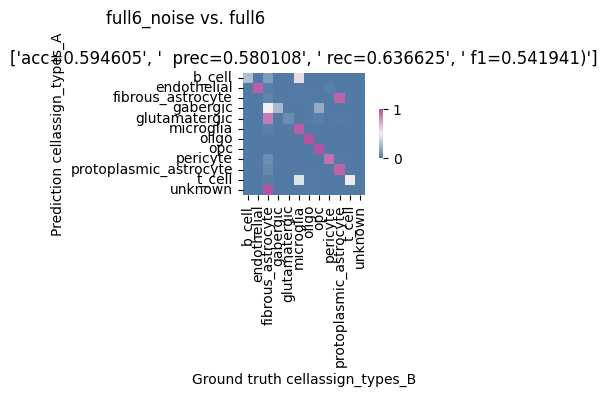

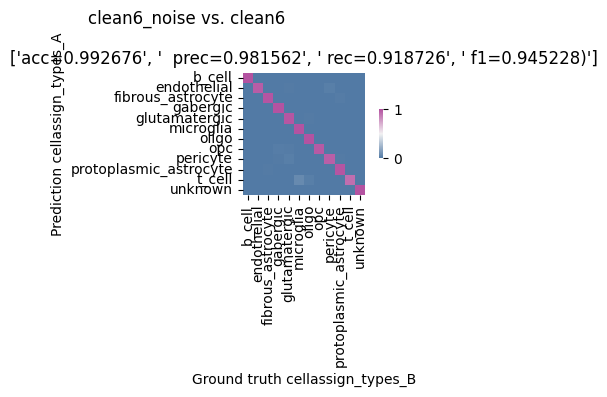

In [6]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6

for samp_set in ["full", "clean"]:
    noise = "_noise"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    noise = ""
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
    )
    print_count_group(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

For the "clean" samples choosing batch correction with continuous covariates (`noise`) doesn't make much of a difference.  However for the "full" set of samples it is crucial.  It seems reasonabl the the "dirty" samples drive this need for more involved batch correction.


### Vanilla and "Noise" sets  Clean vs. Full ("_noise")

 N samples clean6_noise= 840710, N samples full6_noise= 2012744
   (underscore `_` indicates samples matched to clean6_noise samples)
                        clean6_noisepct  full6_noisepct  full6_noisepct_  \
cellassign_types                                                           
oligo                         40.813122       36.448003        40.808483   
glutamatergic                 30.519918       34.424895        30.553580   
gabergic                       7.338321        7.622529         7.353427   
opc                            5.674727        5.866320         5.665093   
protoplasmic_astrocyte         5.657480        6.303136         5.750140   
microglia                      5.588848        5.125391         5.584922   
fibrous_astrocyte              3.153882        2.684395         3.031010   
endothelial                    0.961330        1.190862         0.964066   
pericyte                       0.286544        0.328060         0.284640   
t_cell                        

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean6= 840710, N samples full6= 2012744
   (underscore `_` indicates samples matched to clean6 samples)
                        clean6pct   full6pct  full6pct_  clean6  full6_
cellassign_types                                                       
oligo                   40.938730  36.775218  41.118459  344176  345687
glutamatergic           30.186152   2.824949   3.233814  253778   27187
gabergic                 7.465000   2.107422   2.219315   62759   18658
protoplasmic_astrocyte   5.711720   8.778811   8.594521   48019   72255
microglia                5.590989   5.042569   5.521761   47004   46422
opc                      5.577785   8.269805   7.977067   46893   67064
fibrous_astrocyte        3.209787  34.569374  29.973237   26985  251988
endothelial              0.953480   1.166517   0.947532    8016    7966
pericyte                 0.358744   0.402138   0.349704    3016    2940
t_cell                   0.007018   0.005018   0.004163      59      35
unknown             

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


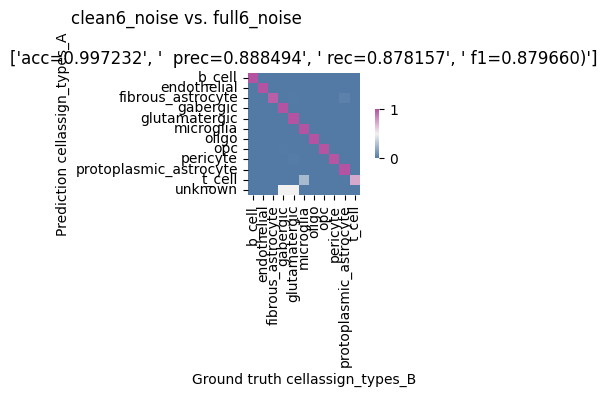

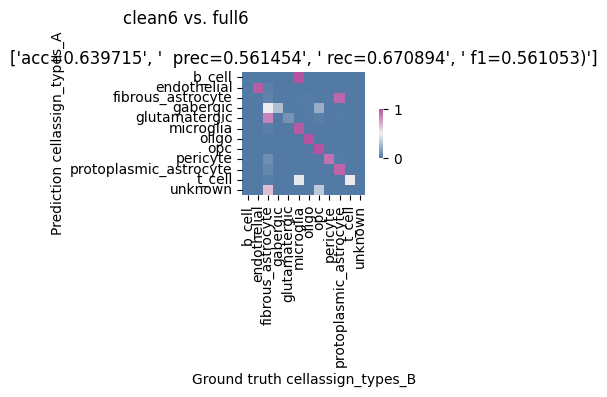

In [7]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6

for noise in ["_noise", ""]:
    samp_set = "clean"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    samp_set = "full"
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )
    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

_Without_ the `noise` batch correction the full dataset (presumably driven by the "dirty" samples) classify many of the neurons as "fibrous_astrocytes" and there is very poor correspondence between the "clean" samples when fit _with_ the "dirty" samples versus alone.  However _with_ batch correction including continuous `noise` covariates (`["doublet_score", "pct_counts_mt", "pct_counts_rb"]` ) the cell type assignments are overal quite accurate between the two datasets.   The notable exception are the "unknown", "t_cell" and "b_cell" assigned cells.  However these represent extremely rare cell types according to this dataset and assignment.

## conclusions

For "ground truth" assignments fitting cellassign with the continusous `noise` covariates on the "full" dataset should give us the most reasonable ground truth. 

Next steps:
- consider further simplified 
- consider alternate ground truth assignment methods which might leverage additional priors.  Here we are only constrained by consistency and the assumed marker genes
- estimate baseline performance of this ground truth designation procedure by analyzing the stability of assignments with different seed values. 

## repeatability...

 N samples full0_noise= 2012744, N samples full1_noise= 2012744
                        full0_noisepct  full1_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean1_noise= 840710
                        clean0_noisepct  clean1_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.807294        343615   
glutamatergic                 33.245828        30.481022        279501   
opc                            8.348063         5.739791         70183   
protoplasmic_astrocyte         5.645823         5.684838         47465   
microglia                      5.596936         5.592416         47054   
fibrous_astrocyte              3.152454         3.130330         26503   
gabergic                       1.790748         7.313342         15055   
endothelial                    0.977626         0.962401          8219   
pericyte                       0.362908         0.287376          3051   
t_cell                         0.003925         0.000119            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0= 840710, N samples clean1= 840710
                        clean0pct  clean1pct  clean0  clean1
cellassign_types                                            
oligo                   41.007006  40.974058  344750  344473
glutamatergic           33.624318  32.370258  282683  272140
opc                      6.045604   6.067134   50826   51007
protoplasmic_astrocyte   5.720165   5.702085   48090   47938
gabergic                 4.535809   4.742182   38133   39868
b_cell                   4.517610   0.001546   37980      13
fibrous_astrocyte        3.212047   3.222395   27004   27091
endothelial              0.958000   0.945748    8054    7951
pericyte                 0.367190   0.368736    3087    3100
microglia                0.012133   5.599791     102   47078
unknown                  0.000119   0.000238       1       2


/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


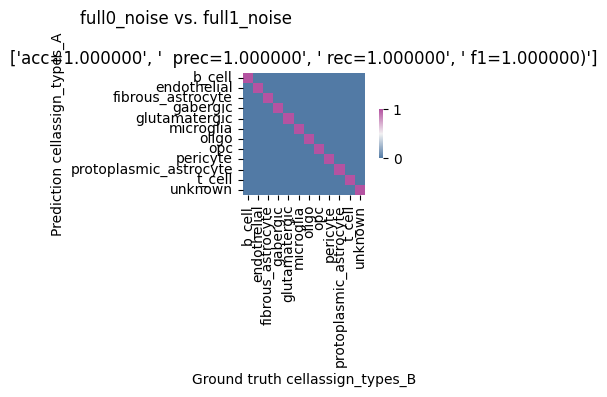

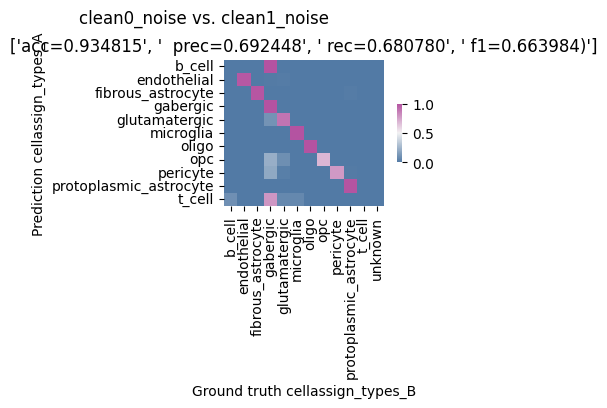

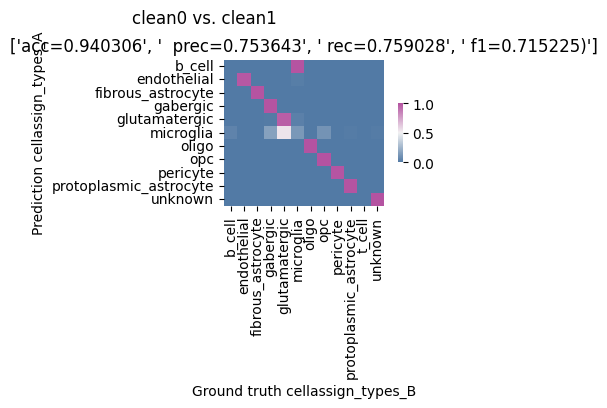

In [8]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 0
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 1
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

### results

Seems to be some great confusion between immune cells:  microglia, t_cell, b_cell, for the clean dataset without the noise parameters.



 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                        full1_noisepct  full2_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean2_noise= 840710
                        clean1_noisepct  clean2_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.905544        343071   
glutamatergic                 30.481022         4.470864        256257   
gabergic                       7.313342        30.068989         61484   
opc                            5.739791         8.767946         48255   
protoplasmic_astrocyte         5.684838         5.622985         47793   
microglia                      5.592416         5.608831         47016   
fibrous_astrocyte              3.130330         3.126881         26317   
endothelial                    0.962401         0.960260          8091   
pericyte                       0.287376         0.328651          2416   
b_cell                         0.000714         0.001546             6   
unknown                        0.000357         

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1= 840710, N samples clean2= 840710
                        clean1pct  clean2pct  clean1    clean2
cellassign_types                                              
oligo                   40.974058  41.047805  344473  345093.0
glutamatergic           32.370258  22.801323  272140  191693.0
opc                      6.067134   5.586944   51007   46970.0
protoplasmic_astrocyte   5.702085   5.754065   47938   48375.0
microglia                5.599791   5.611091   47078   47173.0
gabergic                 4.742182  14.655589   39868  123211.0
fibrous_astrocyte        3.222395   3.220016   27091   27071.0
endothelial              0.945748   0.959189    7951    8064.0
pericyte                 0.368736   0.361361    3100    3038.0
t_cell                   0.005828   0.002617      49      22.0
b_cell                   0.001546        NaN      13       NaN
unknown                  0.000238        NaN       2       NaN


/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


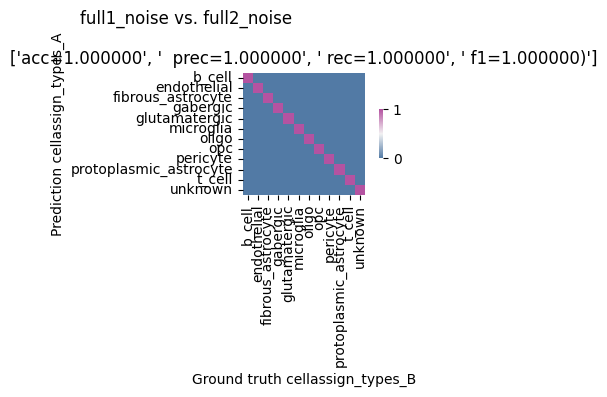

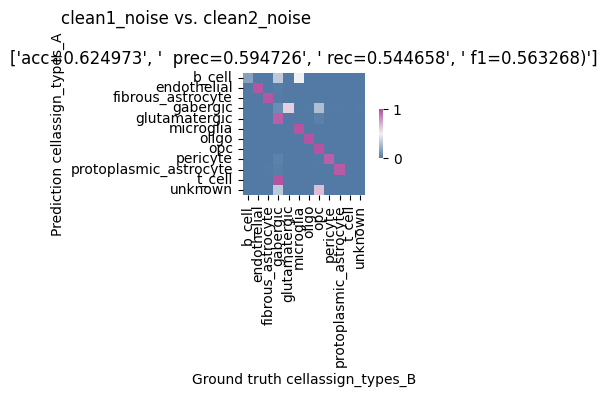

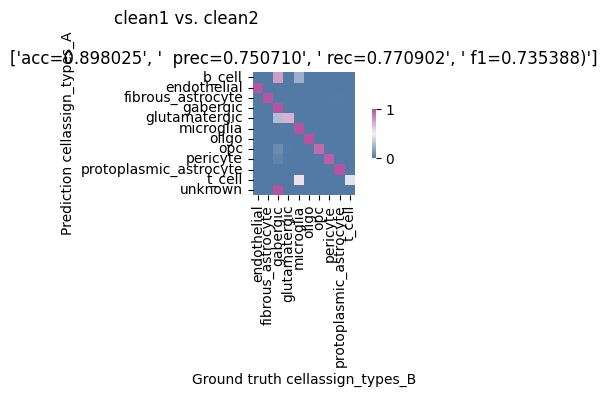

In [9]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 1
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 2
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

 N samples full0_noise= 2012744, N samples full1_noise= 2012744
                        full0_noisepct  full1_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full2_noise= 2012744
                        full0_noisepct  full2_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full3_noise= 2012744
                        full0_noisepct  full3_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full0_noise= 2012744
                        full1_noisepct  full0_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                        full1_noisepct  full2_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full3_noise= 2012744
                        full1_noisepct  full3_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full0_noise= 2012744
                        full2_noisepct  full0_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full1_noise= 2012744
                        full2_noisepct  full1_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full3_noise= 2012744
                        full2_noisepct  full3_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full0_noise= 2012744
                        full3_noisepct  full0_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full1_noise= 2012744
                        full3_noisepct  full1_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full2_noise= 2012744
                        full3_noisepct  full2_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.448003       36.448003       733605   
glutamatergic                34.424895       34.424895       692885   
gabergic                      7.622529        7.622529       153422   
protoplasmic_astrocyte        6.303136        6.303136       126866   
opc                           5.866320        5.866320       118074   
microglia                     5.125391        5.125391       103161   
fibrous_astrocyte             2.684395        2.684395        54030   
endothelial                   1.190862        1.190862        23969   
pericyte                      0.328060        0.328060         6603   
t_cell                        0.005863        0.005863          118   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


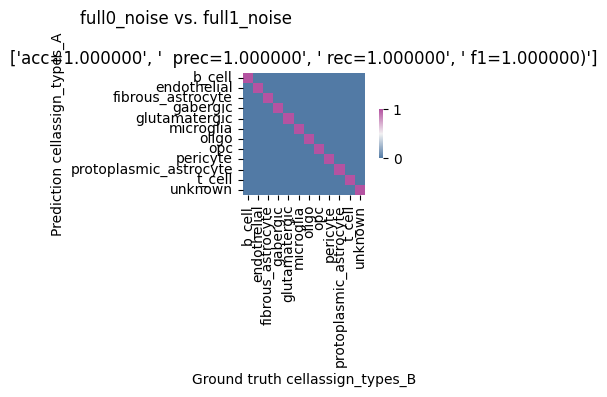

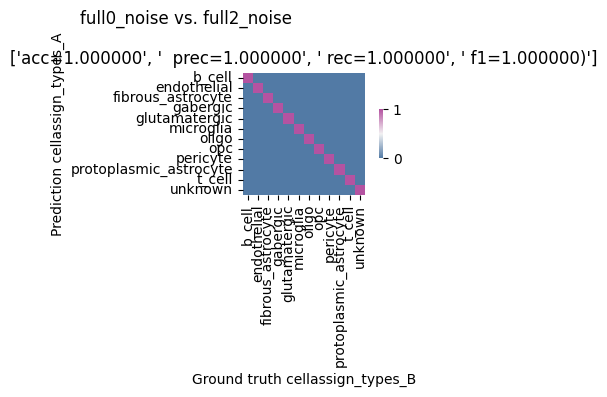

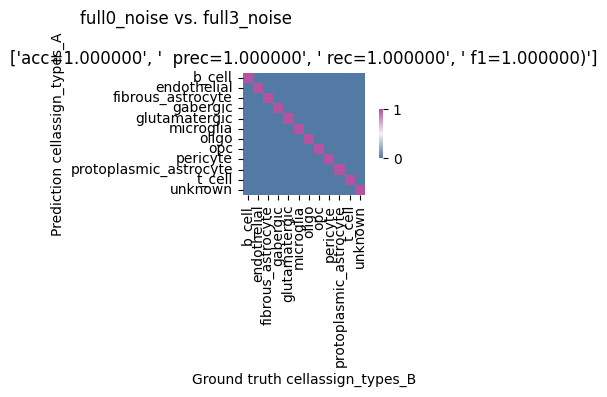

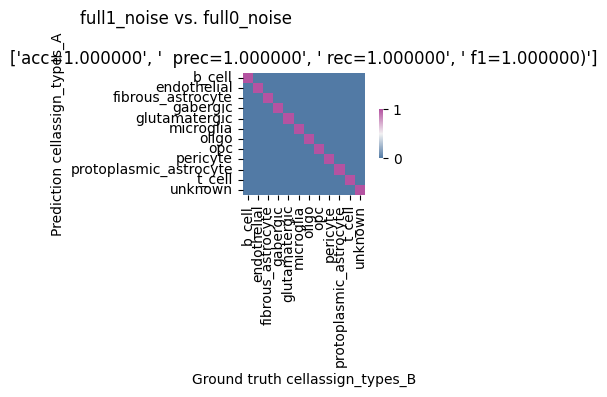

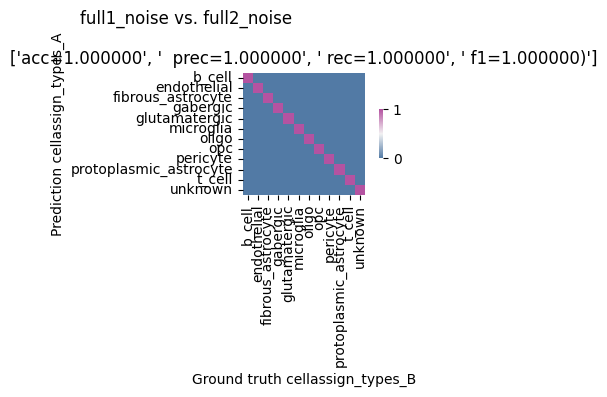

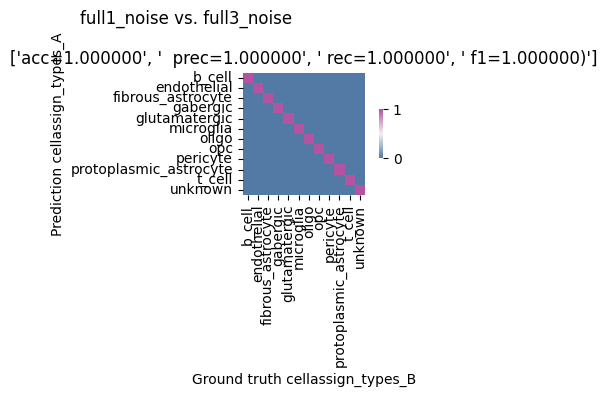

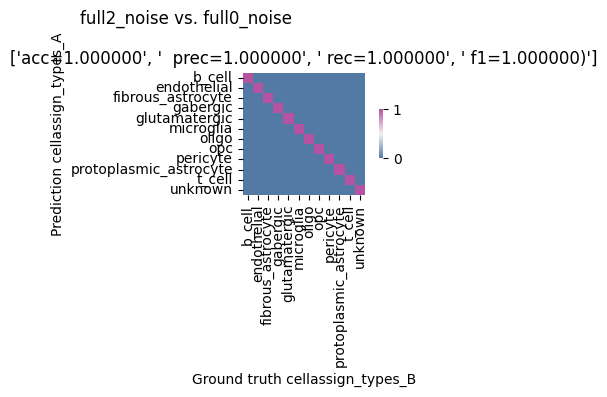

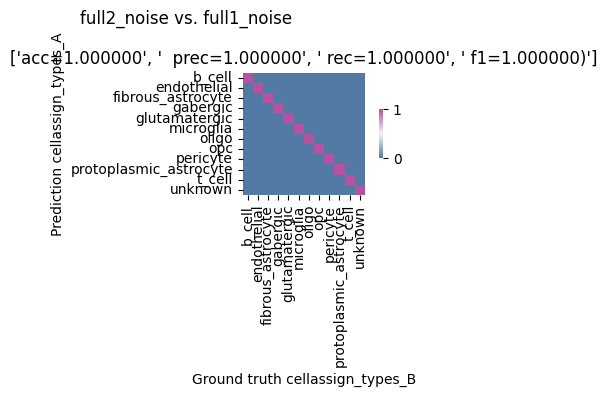

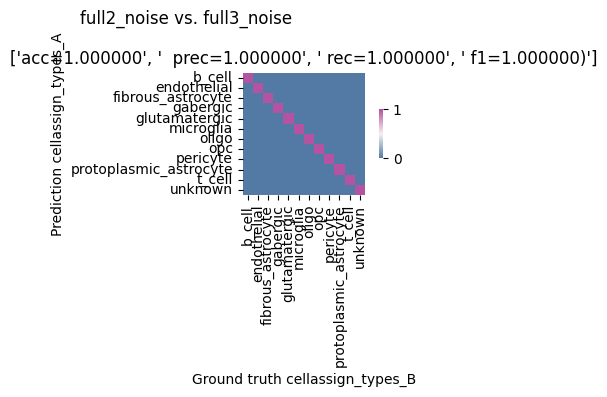

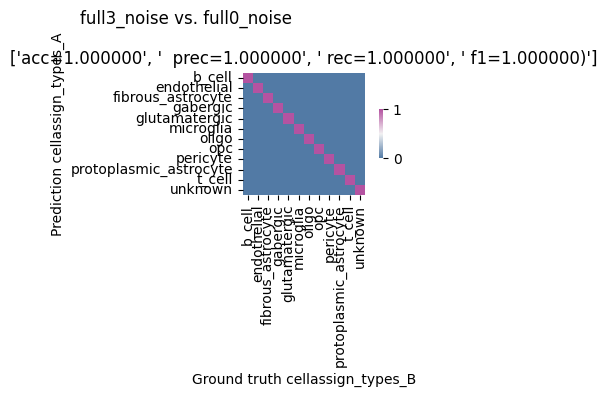

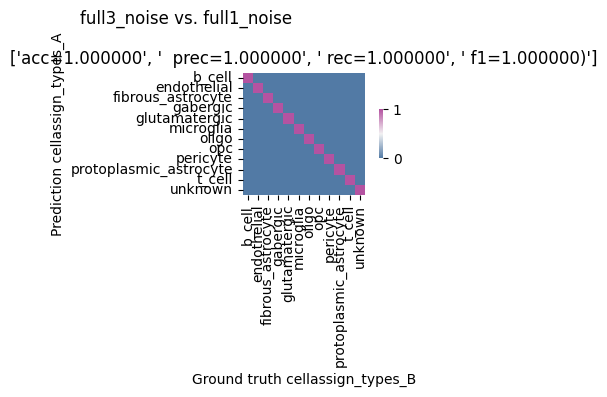

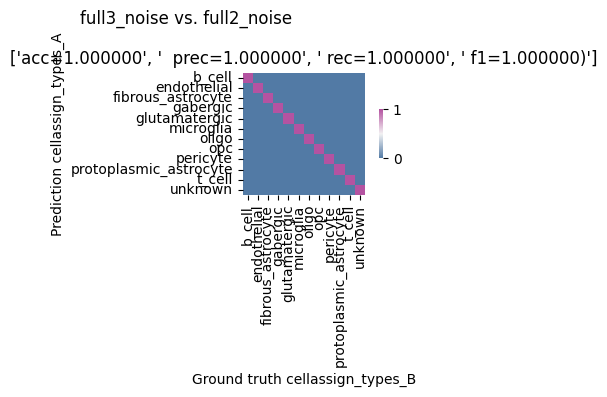

In [10]:
samp_set = "full"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [11]:
samp_set = "full"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

counts 0-3
                        full0_noise  full1_noise  full2_noise  full3_noise
cellassign_types                                                          
oligo                        733605       733605       733605       733605
glutamatergic                692885       692885       692885       692885
gabergic                     153422       153422       153422       153422
protoplasmic_astrocyte       126866       126866       126866       126866
opc                          118074       118074       118074       118074
microglia                    103161       103161       103161       103161
fibrous_astrocyte             54030        54030        54030        54030
endothelial                   23969        23969        23969        23969
pericyte                       6603         6603         6603         6603
t_cell                          118          118          118          118
b_cell                            7            7            7            7
unknown       

 N samples clean0_noise= 840710, N samples clean1_noise= 840710
                        clean0_noisepct  clean1_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.807294        343615   
glutamatergic                 33.245828        30.481022        279501   
opc                            8.348063         5.739791         70183   
protoplasmic_astrocyte         5.645823         5.684838         47465   
microglia                      5.596936         5.592416         47054   
fibrous_astrocyte              3.152454         3.130330         26503   
gabergic                       1.790748         7.313342         15055   
endothelial                    0.977626         0.962401          8219   
pericyte                       0.362908         0.287376          3051   
t_cell                         0.003925         0.000119            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean2_noise= 840710
                        clean0_noisepct  clean2_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.905544        343615   
glutamatergic                 33.245828         4.470864        279501   
opc                            8.348063         8.767946         70183   
protoplasmic_astrocyte         5.645823         5.622985         47465   
microglia                      5.596936         5.608831         47054   
fibrous_astrocyte              3.152454         3.126881         26503   
gabergic                       1.790748        30.068989         15055   
endothelial                    0.977626         0.960260          8219   
pericyte                       0.362908         0.328651          3051   
t_cell                         0.003925         0.005591            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean3_noise= 840710
                        clean0_noisepct  clean3_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.898764        343615   
glutamatergic                 33.245828        25.743241        279501   
opc                            8.348063         5.661524         70183   
protoplasmic_astrocyte         5.645823         5.684957         47465   
microglia                      5.596936         5.594081         47054   
fibrous_astrocyte              3.152454         3.166609         26503   
gabergic                       1.790748        11.987844         15055   
endothelial                    0.977626         0.968705          8219   
pericyte                       0.362908         0.288328          3051   
t_cell                         0.003925         0.005591            33   
b_cell                         0.003687         

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean0_noise= 840710
                        clean1_noisepct  clean0_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.872001        343071   
glutamatergic                 30.481022        33.245828        256257   
gabergic                       7.313342         1.790748         61484   
opc                            5.739791         8.348063         48255   
protoplasmic_astrocyte         5.684838         5.645823         47793   
microglia                      5.592416         5.596936         47016   
fibrous_astrocyte              3.130330         3.152454         26317   
endothelial                    0.962401         0.977626          8091   
pericyte                       0.287376         0.362908          2416   
b_cell                         0.000714         0.003687             6   
unknown                        0.000357         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean2_noise= 840710
                        clean1_noisepct  clean2_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.905544        343071   
glutamatergic                 30.481022         4.470864        256257   
gabergic                       7.313342        30.068989         61484   
opc                            5.739791         8.767946         48255   
protoplasmic_astrocyte         5.684838         5.622985         47793   
microglia                      5.592416         5.608831         47016   
fibrous_astrocyte              3.130330         3.126881         26317   
endothelial                    0.962401         0.960260          8091   
pericyte                       0.287376         0.328651          2416   
b_cell                         0.000714         0.001546             6   
unknown                        0.000357         

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean3_noise= 840710
                        clean1_noisepct  clean3_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.898764        343071   
glutamatergic                 30.481022        25.743241        256257   
gabergic                       7.313342        11.987844         61484   
opc                            5.739791         5.661524         48255   
protoplasmic_astrocyte         5.684838         5.684957         47793   
microglia                      5.592416         5.594081         47016   
fibrous_astrocyte              3.130330         3.166609         26317   
endothelial                    0.962401         0.968705          8091   
pericyte                       0.287376         0.288328          2416   
b_cell                         0.000714         0.000357             6   
unknown                        0.000357         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 840710, N samples clean0_noise= 840710
                        clean2_noisepct  clean0_noisepct  clean2_noise  \
cellassign_types                                                         
oligo                         40.905544        40.872001        343897   
gabergic                      30.068989         1.790748        252793   
opc                            8.767946         8.348063         73713   
protoplasmic_astrocyte         5.622985         5.645823         47273   
microglia                      5.608831         5.596936         47154   
glutamatergic                  4.470864        33.245828         37587   
fibrous_astrocyte              3.126881         3.152454         26288   
endothelial                    0.960260         0.977626          8073   
pericyte                       0.328651         0.362908          2763   
unknown                        0.131912              NaN          1109   
t_cell                         0.005591         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 840710, N samples clean1_noise= 840710
                        clean2_noisepct  clean1_noisepct  clean2_noise  \
cellassign_types                                                         
oligo                         40.905544        40.807294        343897   
gabergic                      30.068989         7.313342        252793   
opc                            8.767946         5.739791         73713   
protoplasmic_astrocyte         5.622985         5.684838         47273   
microglia                      5.608831         5.592416         47154   
glutamatergic                  4.470864        30.481022         37587   
fibrous_astrocyte              3.126881         3.130330         26288   
endothelial                    0.960260         0.962401          8073   
pericyte                       0.328651         0.287376          2763   
unknown                        0.131912         0.000357          1109   
t_cell                         0.005591         

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 840710, N samples clean3_noise= 840710
                        clean2_noisepct  clean3_noisepct  clean2_noise  \
cellassign_types                                                         
oligo                         40.905544        40.898764        343897   
gabergic                      30.068989        11.987844        252793   
opc                            8.767946         5.661524         73713   
protoplasmic_astrocyte         5.622985         5.684957         47273   
microglia                      5.608831         5.594081         47154   
glutamatergic                  4.470864        25.743241         37587   
fibrous_astrocyte              3.126881         3.166609         26288   
endothelial                    0.960260         0.968705          8073   
pericyte                       0.328651         0.288328          2763   
unknown                        0.131912              NaN          1109   
t_cell                         0.005591         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 840710, N samples clean0_noise= 840710
                        clean3_noisepct  clean0_noisepct  clean3_noise  \
cellassign_types                                                         
oligo                         40.898764        40.872001        343840   
glutamatergic                 25.743241        33.245828        216426   
gabergic                      11.987844         1.790748        100783   
protoplasmic_astrocyte         5.684957         5.645823         47794   
opc                            5.661524         8.348063         47597   
microglia                      5.594081         5.596936         47030   
fibrous_astrocyte              3.166609         3.152454         26622   
endothelial                    0.968705         0.977626          8144   
pericyte                       0.288328         0.362908          2424   
t_cell                         0.005591         0.003925            47   
b_cell                         0.000357         

/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 840710, N samples clean1_noise= 840710
                        clean3_noisepct  clean1_noisepct  clean3_noise  \
cellassign_types                                                         
oligo                         40.898764        40.807294        343840   
glutamatergic                 25.743241        30.481022        216426   
gabergic                      11.987844         7.313342        100783   
protoplasmic_astrocyte         5.684957         5.684838         47794   
opc                            5.661524         5.739791         47597   
microglia                      5.594081         5.592416         47030   
fibrous_astrocyte              3.166609         3.130330         26622   
endothelial                    0.968705         0.962401          8144   
pericyte                       0.288328         0.287376          2424   
t_cell                         0.005591         0.000119            47   
b_cell                         0.000357         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 840710, N samples clean2_noise= 840710
                        clean3_noisepct  clean2_noisepct  clean3_noise  \
cellassign_types                                                         
oligo                         40.898764        40.905544        343840   
glutamatergic                 25.743241         4.470864        216426   
gabergic                      11.987844        30.068989        100783   
protoplasmic_astrocyte         5.684957         5.622985         47794   
opc                            5.661524         8.767946         47597   
microglia                      5.594081         5.608831         47030   
fibrous_astrocyte              3.166609         3.126881         26622   
endothelial                    0.968705         0.960260          8144   
pericyte                       0.288328         0.328651          2424   
t_cell                         0.005591         0.005591            47   
b_cell                         0.000357         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1552818/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


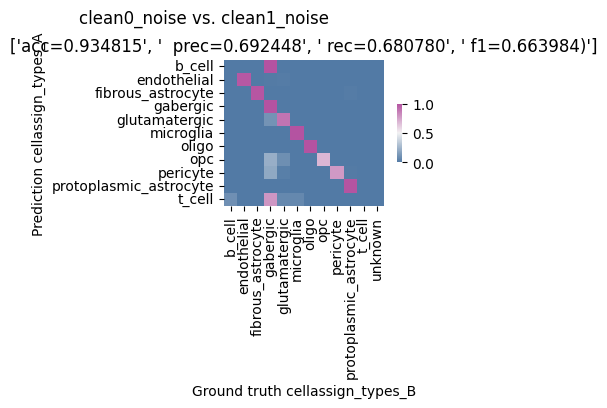

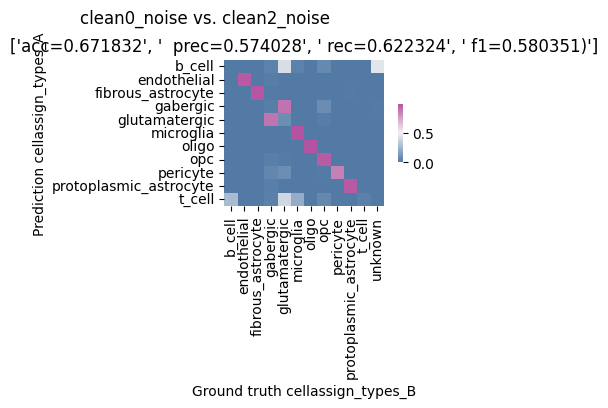

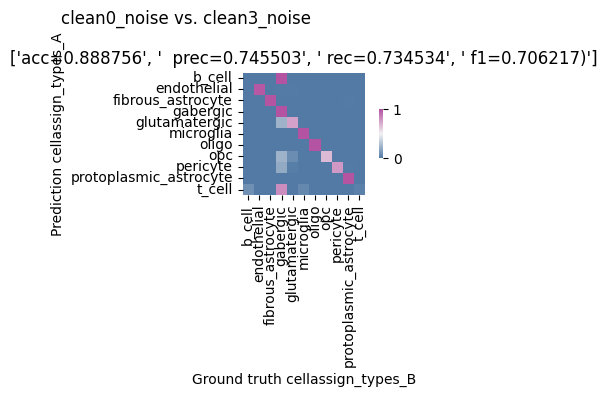

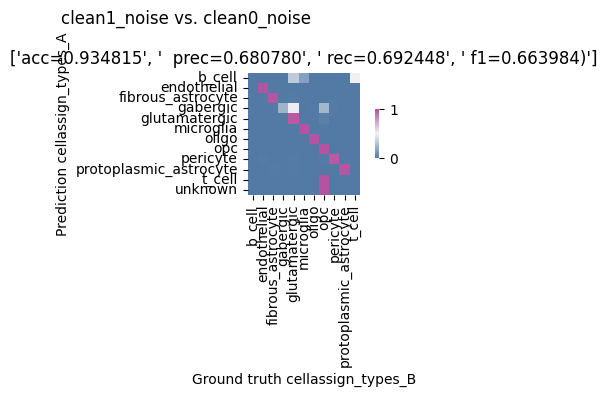

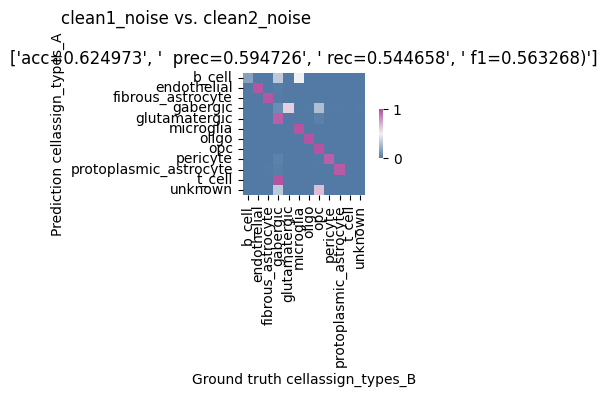

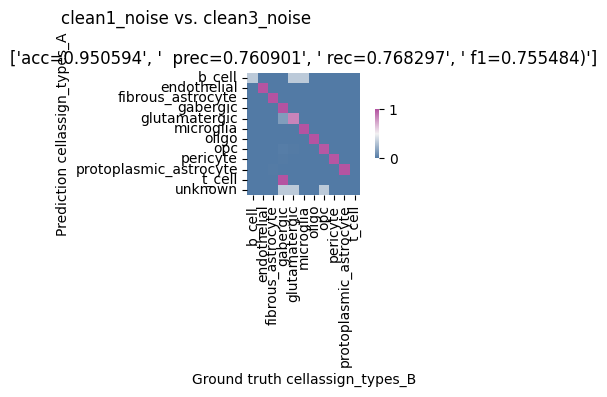

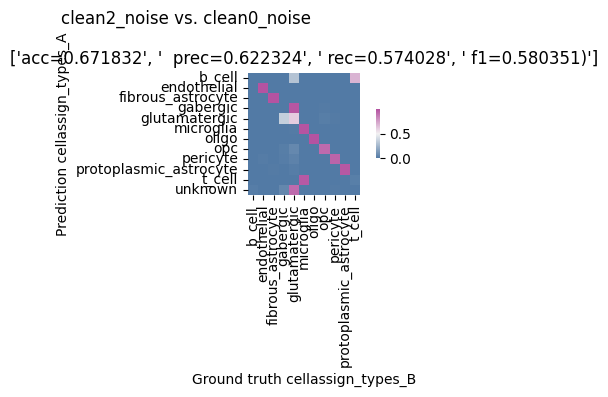

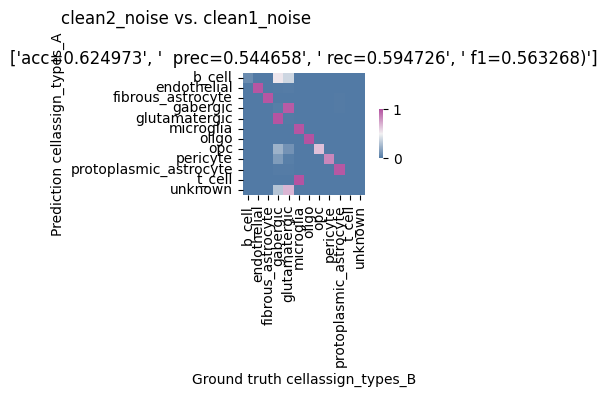

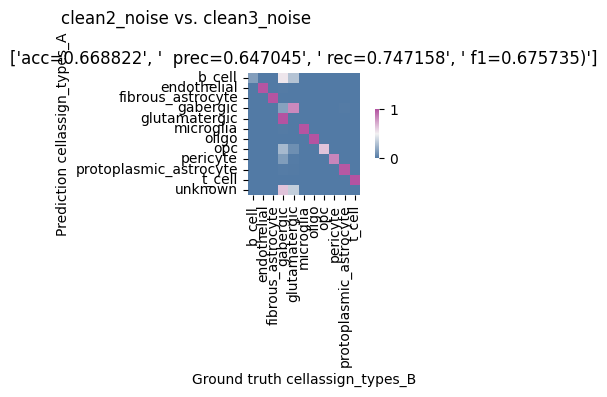

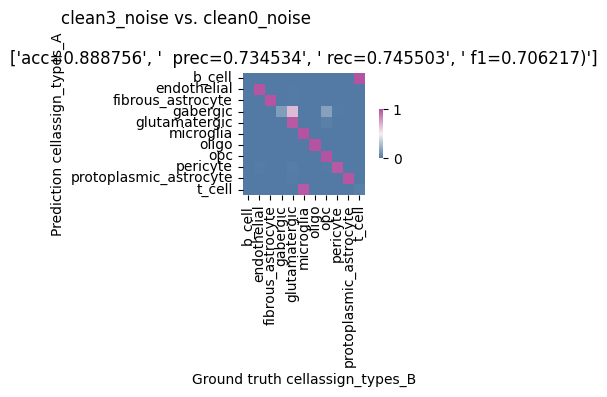

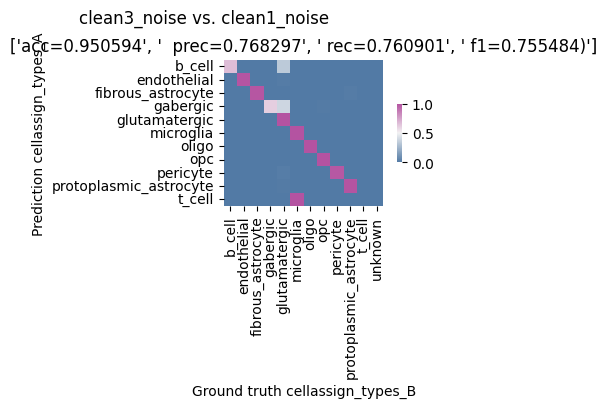

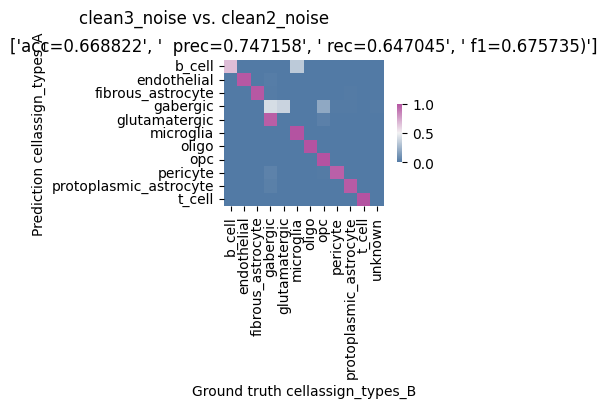

In [12]:
samp_set = "clean"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [13]:
samp_set = "clean"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

counts 0-3
                        clean0_noise  clean1_noise  clean2_noise  clean3_noise
cellassign_types                                                              
oligo                         343615        343071        343897        343840
glutamatergic                 279501        256257         37587        216426
opc                            70183         48255         73713         47597
protoplasmic_astrocyte         47465         47793         47273         47794
microglia                      47054         47016         47154         47030
fibrous_astrocyte              26503         26317         26288         26622
gabergic                       15055         61484        252793        100783
endothelial                     8219          8091          8073          8144
pericyte                        3051          2416          2763          2424
t_cell                            33             1            47            47
b_cell                            31     

In [14]:
preds

NameError: name 'preds' is not defined

In [15]:
predictions

,oligo,opc,glutamatergic,gabergic,protoplasmic_astrocyte,fibrous_astrocyte,microglia,t_cell,b_cell,pericyte,endothelial,unknown,cellassign_types,cell_type,sample,cell
AGCTTAATCCTTAAGA-1_1134-ARC,8.070967e-19,2.066018e-07,6.553242e-14,3.515823e-15,1.660158e-11,9.999924e-01,5.075886e-06,1.170981e-17,2.266605e-06,1.079137e-17,1.577539e-20,2.580642e-09,fibrous_astrocyte,glutamatergic,1134-ARC,AGCTTAATCCTTAAGA-1_1134-ARC
TATATCCTCTTGATGA-1_1134-ARC,6.801635e-23,8.827080e-08,8.033812e-09,1.859673e-12,4.399218e-11,9.997374e-01,2.359720e-04,7.018505e-15,2.650754e-05,4.066693e-18,8.359755e-16,3.124652e-08,fibrous_astrocyte,glutamatergic,1134-ARC,TATATCCTCTTGATGA-1_1134-ARC
ACACAATGTACTAAAC-1_1134-ARC,8.071695e-26,1.124705e-09,2.038490e-09,2.960360e-13,6.147943e-08,9.999971e-01,1.045800e-06,1.447950e-24,1.758187e-06,4.517531e-20,3.295211e-17,2.097122e-09,fibrous_astrocyte,glutamatergic,1134-ARC,ACACAATGTACTAAAC-1_1134-ARC
CTAGATTCATGTCAGC-1_1134-ARC,3.632498e-24,1.119848e-06,4.563372e-06,1.232154e-10,1.248253e-10,9.978832e-01,4.800004e-04,3.658783e-12,1.629206e-03,2.308527e-16,1.558395e-12,1.956315e-06,fibrous_astrocyte,glutamatergic,1134-ARC,CTAGATTCATGTCAGC-1_1134-ARC
AATGTCATCATAATCG-1_1134-ARC,4.018614e-25,4.830847e-10,4.800599e-07,3.304295e-13,3.234424e-08,9.999829e-01,1.639706e-06,4.083418e-14,1.493679e-05,9.614743e-20,7.887875e-16,1.796647e-08,fibrous_astrocyte,glutamatergic,1134-ARC,AATGTCATCATAATCG-1_1134-ARC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAACAGAGTCACCTC-1_UMARY-933-ARC,2.656263e-17,1.000000e+00,1.607677e-17,1.350737e-17,4.094026e-17,3.722711e-16,2.597679e-17,5.181004e-24,8.750678e-22,1.476936e-18,2.228320e-18,4.607009e-22,opc,opc,UMARY-933-ARC,ACAACAGAGTCACCTC-1_UMARY-933-ARC
CTACTAAAGCTAATTG-1_UMARY-933-ARC,5.443109e-02,3.364262e-02,3.140698e-02,2.614744e-02,8.021798e-02,7.159961e-01,5.077026e-02,3.229378e-09,1.910092e-06,2.905543e-03,4.479178e-03,8.858699e-07,fibrous_astrocyte,glutamatergic,UMARY-933-ARC,CTACTAAAGCTAATTG-1_UMARY-933-ARC
CATTGTAAGCAACAAG-1_UMARY-933-ARC,2.631828e-02,1.682088e-02,4.117222e-01,9.748156e-02,4.116664e-02,3.766419e-01,2.614240e-02,7.502265e-09,8.488473e-07,1.483117e-03,2.221772e-03,4.661459e-07,glutamatergic,glutamatergic,UMARY-933-ARC,CATTGTAAGCAACAAG-1_UMARY-933-ARC
GCTAAGAAGTTATTCC-1_UMARY-933-ARC,5.277312e-02,3.307912e-02,3.127264e-02,2.616840e-02,7.974229e-02,7.191500e-01,5.054014e-02,6.118936e-09,1.788162e-06,2.881873e-03,4.389688e-03,8.898865e-07,fibrous_astrocyte,glutamatergic,UMARY-933-ARC,GCTAAGAAGTTATTCC-1_UMARY-933-ARC


In [ ]:
def get_stats_from_probs(predictions: pd.DataFrame, cell_types: list) -> pd.DataFrame:
    """
    Get probabilities, entropy, log entropy, labels, and margin of probability.
    """
    # Applying softmax to convert logits to probabilities
    probabilities = predictions[cell_types].values

    # Calculate entropy
    entropy = -np.sum(probabilities * np.log(probabilities), axis=1)

    # n_classes = probabilities.shape[1]
    logents = entropy.log().numpy()

    # print("Logits: ", logs)
    # print("Probabilities: ", probs)

    maxprobs = probabilities.max(axis=1)

    # Binarize the true labels for each class
    from sklearn.preprocessing import label_binarize

    labels = label_binarize(y_true, classes=np.arange(len(cell_types)))

    labels = categories[probabilities.argmax(axis=1)]

    margin = calculate_margin_of_probability(probabilities)

    return {
        "logit": logs,
        "prob": probs,
        "entropy": ents,
        "logE": logents,
        "max_p": maxprobs,
        "mop": margin,
        "label": labels,
    }


def calculate_margin_of_probability(probabilities: torch.Tensor) -> np.ndarray:
    """
    Calculate the margin of probability.

    Parameters
    ----------
    probabilities : torch.Tensor
        Probabilities from a model.

    Returns
    -------
    np.ndarray
        Array of margin of probability.
    """
    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:, 0] - top_probs[:, 1]
    return margin.numpy()

In [17]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cell_barcode_labels.csv", index_col=0
)

In [18]:
ground_truth.head()

,seurat_clusters,cell_type,sample
cells,,,
GGCCTAATCGATTTAG-1_1,11,Mature neurons,KEN-1070-ARC
TAGTAACGTAGTCAAT-1_1,5,Mature neurons,KEN-1070-ARC
GAAAGCCAGCAGCTCA-1_1,2,Oligodendrocytes,KEN-1070-ARC
ACTCACCTCCTCCCTC-1_1,5,Mature neurons,KEN-1070-ARC
CTTCATCCAATCGCAC-1_1,11,Mature neurons,KEN-1070-ARC


In [19]:
ground_truth.shape

(713626, 3)

In [21]:
ground_truth.cell_type.value_counts()

cell_type
Oligodendrocytes                   287587
Mature neurons                      99925
Glutamatergic neurons               84684
GABAergic neurons                   81731
Astrocytes                          54362
Oligodendrocyte precursor cells     41993
Microglial cells                    40227
Radial glial cells                  15998
Endothelial cells                    7119
Name: count, dtype: int64

In [22]:
100 * ground_truth.cell_type.value_counts() / ground_truth.shape[0]

cell_type
Oligodendrocytes                   40.299401
Mature neurons                     14.002433
Glutamatergic neurons              11.866720
GABAergic neurons                  11.452918
Astrocytes                          7.617716
Oligodendrocyte precursor cells     5.884455
Microglial cells                    5.636986
Radial glial cells                  2.241791
Endothelial cells                   0.997581
Name: count, dtype: float64

In [23]:
ground_truth.sample.value_counts()

AttributeError: 'function' object has no attribute 'value_counts'

In [25]:
ground_truth["sample"].value_counts()

sample
KEN-1159-ARC      11317
UMARY-5088-ARC    11247
UMARY-871-ARC     11118
KEN-1066-ARC      10280
SH-92-05-ARC       9325
                  ...  
UMARY-1465-ARC     1173
UMARY-4263-ARC     1103
UMARY-5028-ARC      818
UMARY-4842-ARC      368
UMARY-1789-ARC      255
Name: count, Length: 138, dtype: int64

In [27]:
adata.obs._cell_type.value_counts()

_cell_type
NONE    2012744
Name: count, dtype: int64

PosixPath('/home/ergonyc/Projects/SingleCell/labelator/data/scdata/xylena_raw')

In [35]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [36]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [37]:
adata.obs.cell_type.value_counts()

cell_type
Oligo    321846
ExN      161024
InN       78813
Astro     61165
OPC       41691
MG        37581
VC         7678
Name: count, dtype: int64

In [38]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [39]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [40]:
adata.obs.cell_type.value_counts()

cell_type
Oligo    321846
ExN      161024
InN       78813
Astro     61165
OPC       41691
MG        37581
VC         7678
Name: count, dtype: int64

In [41]:
100 * adata.obs.cell_type.value_counts() / adata.shape[0]

cell_type
Oligo    45.342493
ExN      22.685475
InN      11.103378
Astro     8.617083
OPC       5.873535
MG        5.294508
VC        1.081696
Name: count, dtype: float64

In [42]:
adata.head()

AttributeError: 'AnnData' object has no attribute 'head'

In [43]:
adata.obs.head()

,seurat_clusters,cell_type,sample
cells,,,
GGCCTAATCGATTTAG-1_1,8,ExN,KEN-1070-ARC
TAGTAACGTAGTCAAT-1_1,2,ExN,KEN-1070-ARC
GAAAGCCAGCAGCTCA-1_1,2,ExN,KEN-1070-ARC
ACTCACCTCCTCCCTC-1_1,2,ExN,KEN-1070-ARC
CTTCATCCAATCGCAC-1_1,8,ExN,KEN-1070-ARC


In [46]:
adata.obs["sample"].value_counts()

sample
KEN-1159-ARC      11317
UMARY-5088-ARC    11247
KEN-1066-ARC      10280
SH-92-05-ARC       9325
SH-03-15-ARC       9055
                  ...  
UMARY-4727-ARC     1554
UMARY-1465-ARC     1173
UMARY-4263-ARC     1103
UMARY-5028-ARC      828
UMARY-1789-ARC      255
Name: count, Length: 138, dtype: int64

In [47]:
adata.shape

(709811, 3000)

In [48]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [49]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cellassign_predictions_feb13.csv",
    index_col=0,
)

In [50]:
ground_truth.head()

,sample,cellassign_types
cells,,
AGCTTAATCCTTAAGA-1_1134-ARC,1134-ARC,InN
TATATCCTCTTGATGA-1_1134-ARC,1134-ARC,InN
ACACAATGTACTAAAC-1_1134-ARC,1134-ARC,ExN
CTAGATTCATGTCAGC-1_1134-ARC,1134-ARC,InN
AATGTCATCATAATCG-1_1134-ARC,1134-ARC,InN
